In [3]:
#initialize
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
 
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
#hyperparameters
num_classes = 10
in_channel = 1
learning_rate = 0.001
batch_size = 128
num_epochs = 30

In [4]:
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
csv_data ='/content/gdrive/MyDrive/AIC/AIcomm_project_1_train.csv' 

cols = list(pd.read_csv(csv_data, nrows =1))

csv_features = pd.read_csv(csv_data, index_col = 0, usecols =[i for i in cols if i != 'label'])
csv_label = pd.read_csv(csv_data, index_col = 0, usecols=[0, 1])


In [8]:
# train , validation 데이터 분리
scaler = StandardScaler()

train_features, valid_features, train_labels, valid_labels = train_test_split(csv_features.values, csv_label.values, train_size = 0.8)

train_features = scaler.fit_transform(train_features)
valid_features = scaler.transform(valid_features)

train_features = train_features.reshape(48000,28,28)
valid_features = valid_features.reshape(12000,28,28)

train_features = train_features.reshape(-1, 1, 28, 28)
valid_features = valid_features.reshape(-1, 1, 28, 28)

In [9]:
#data augmentation

transforms_augmentation = transforms.Compose([transforms.Resize((28,28)),
                           transforms.RandomCrop(28, padding= 4),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transforms_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

class aug_DataSet(Dataset):
  def __init__(self, train_x, train_y, transform=transforms_augmentation):
    self.X = train_x
    self.y = train_y
    self.transform = transform   

  def __getitem__(self, item):
    x_t = torch.Tensor(self.X[item])
    y_t = self.y[item]
    return (x_t, int(y_t))
  def __len__(self):
    return len(self.X)

class DataSet(Dataset):
  def __init__(self, train_x, train_y, transform=transforms_transform):
    self.X = train_x
    self.y = train_y
    self.transform = transform      

  def __getitem__(self, item):
    x_t = torch.Tensor(self.X[item])
    y_t = self.y[item]
    return (x_t, int(y_t))
  def __len__(self):
    return len(self.X)

In [10]:
dataset_train = aug_DataSet(train_features, train_labels)
dataset_valid = DataSet(valid_features, valid_labels)

train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(dataset = dataset_valid, batch_size = batch_size, shuffle = True)

In [11]:
from torchvision import models

resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [12]:
class ResNet(nn.Module):
  def __init__(self, in_channels, resnet18, num_classes):
    super(ResNet, self).__init__()
    self.model = resnet18
    self.model.conv1 = nn.Conv2d(1, 64, 3)
    self.model.fc = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.model(x)

    return x

In [13]:
model = ResNet(in_channel,resnet18,num_classes).to(device)

#Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=0.1)

In [14]:
model

ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

Epoch [1/30], Loss: 0.2373, Train Accuracy: 83.59%, Valid Accuracy: 82.81%
Epoch [2/30], Loss: 0.3516, Train Accuracy: 89.84%, Valid Accuracy: 92.19%
Epoch [3/30], Loss: 0.1980, Train Accuracy: 93.75%, Valid Accuracy: 89.84%
Epoch [4/30], Loss: 0.2346, Train Accuracy: 92.97%, Valid Accuracy: 85.94%
Epoch [5/30], Loss: 0.1665, Train Accuracy: 95.31%, Valid Accuracy: 91.41%
Epoch [6/30], Loss: 0.2262, Train Accuracy: 96.88%, Valid Accuracy: 89.84%
Epoch [7/30], Loss: 0.1236, Train Accuracy: 99.22%, Valid Accuracy: 89.84%
Epoch [8/30], Loss: 0.0973, Train Accuracy: 96.88%, Valid Accuracy: 95.31%
Epoch [9/30], Loss: 0.1385, Train Accuracy: 97.66%, Valid Accuracy: 91.41%
Epoch [10/30], Loss: 0.0826, Train Accuracy: 95.31%, Valid Accuracy: 92.19%
Epoch [11/30], Loss: 0.1252, Train Accuracy: 99.22%, Valid Accuracy: 85.94%
Epoch [12/30], Loss: 0.0459, Train Accuracy: 99.22%, Valid Accuracy: 92.97%
Epoch [13/30], Loss: 0.0766, Train Accuracy: 96.88%, Valid Accuracy: 92.19%
Epoch [14/30], Loss: 

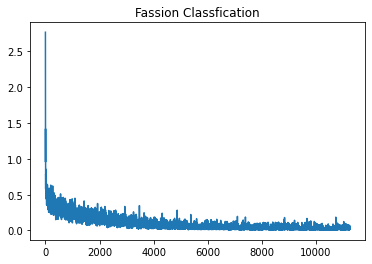

In [15]:
# Train

total_step = len(train_loader)
loss_list = []
best_acc = 0

for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(train_loader):


    # Assign Tensors to Configured Device
    images, labels = Variable(data.float()).to(device), Variable(labels.type(torch.LongTensor)).to(device)

    # Forward Propagation
    outputs = model(images)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    # Print Loss to track Training process
    if (i+1)==len(train_loader):
      
      train_acc = 0
      train_image, train_label = next(iter(train_loader))
      train_image, train_label = Variable(train_image.float()).to(device), Variable(train_label.type(torch.LongTensor)).to(device)

      _, train_predicted = torch.max(model(train_image.to(device)).data, 1)

      for (pred, ans) in zip(train_predicted, train_label):
        if pred == ans:
          train_acc += 1
      train_acc = train_acc / len(train_predicted)

      valid_acc = 0
      valid_image, valid_label = next(iter(valid_loader))
      valid_image, valid_label = Variable(valid_image.float()).to(device), Variable(valid_label.type(torch.LongTensor)).to(device)

      _, valid_predicted = torch.max(model(valid_image.to(device)).data, 1)
      
      for (pred, ans) in zip(valid_predicted, valid_label):
        if pred == ans:
          valid_acc += 1
      valid_acc = valid_acc / len(valid_predicted)

      if best_acc < valid_acc:
          best_acc = valid_acc
          torch.save(model.state_dict(), 'Fassion_Classification.pth')

      print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Valid Accuracy: {:.2f}%'.format(epoch+1,num_epochs, loss.item(), train_acc*100, valid_acc*100))

plt.plot(loss_list)
plt.title("Fassion Classfication")
plt.show()